Activity coefficient of NH3: 2.4334744003503066
Activity coefficient of H2O: 1.9463244612428332
Activity coefficient of CH4: 2.4589530017445815
Activity coefficient of CO2: 2.6088393776269725
Activity coefficient of NO: 2.515484684016368
Activity coefficient of O2: 2.5914948132651334
Activity coefficient of H2: 2.52231617397249
Activity coefficient of CO: 2.664456241929417


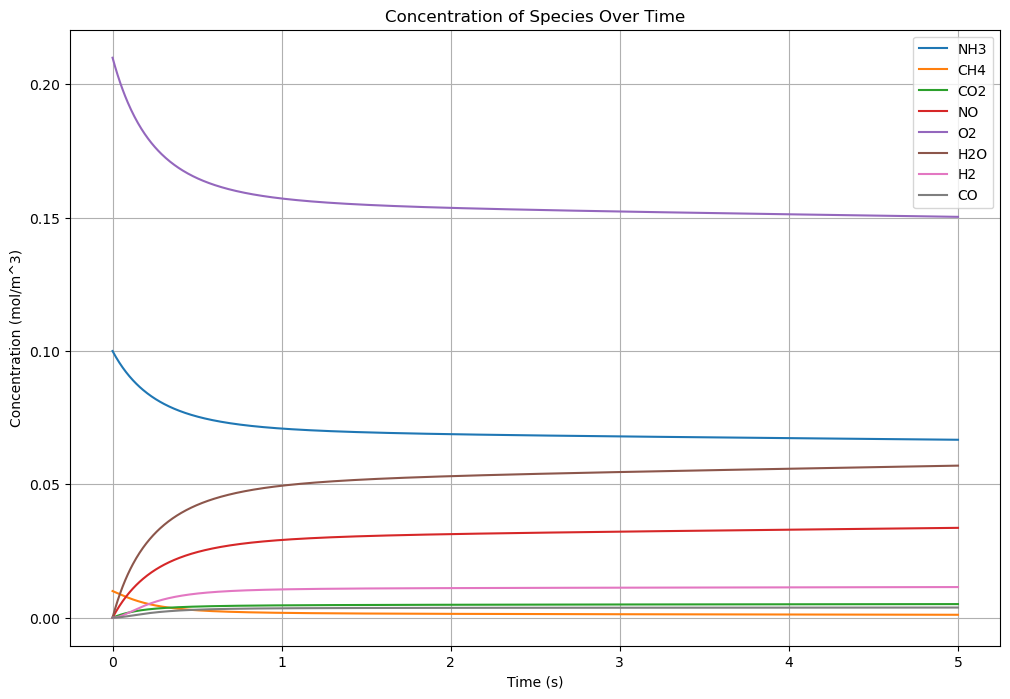

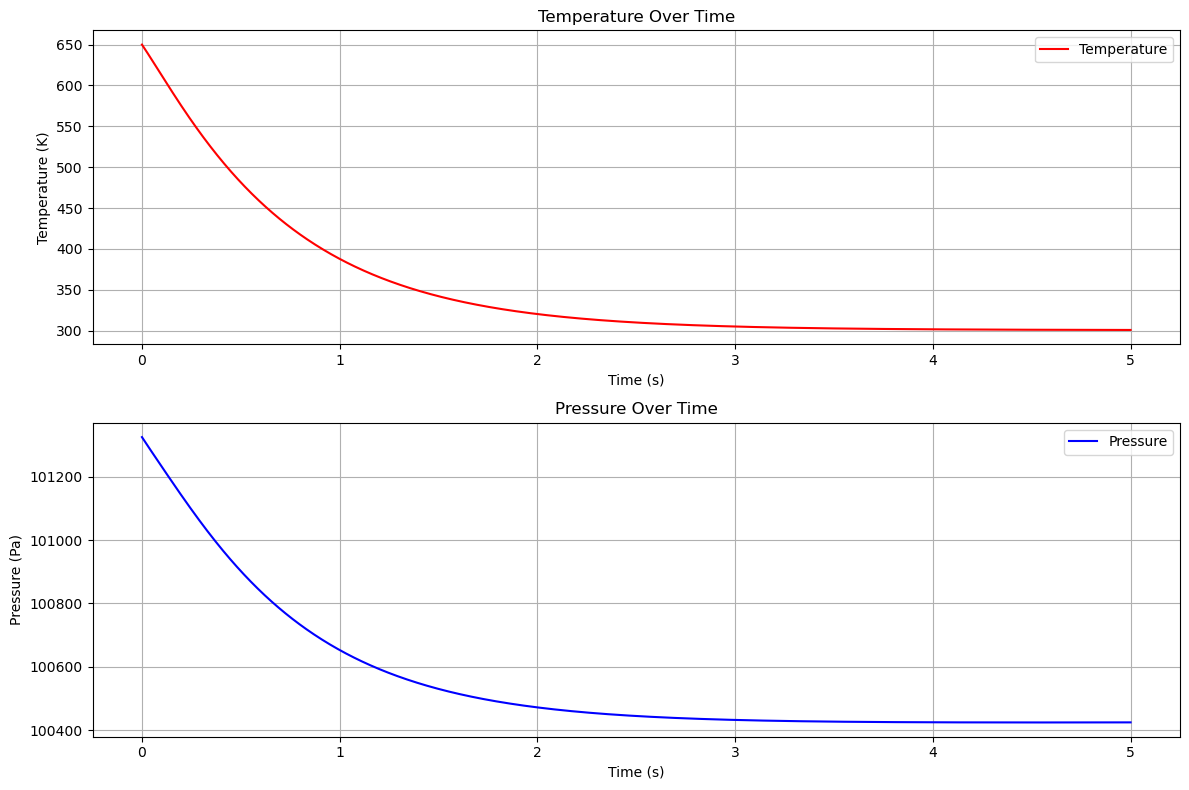

CH4 conversion: 0.89
CO2 selectivity from CH4: 0.57
CO2 yield from CH4: 0.51


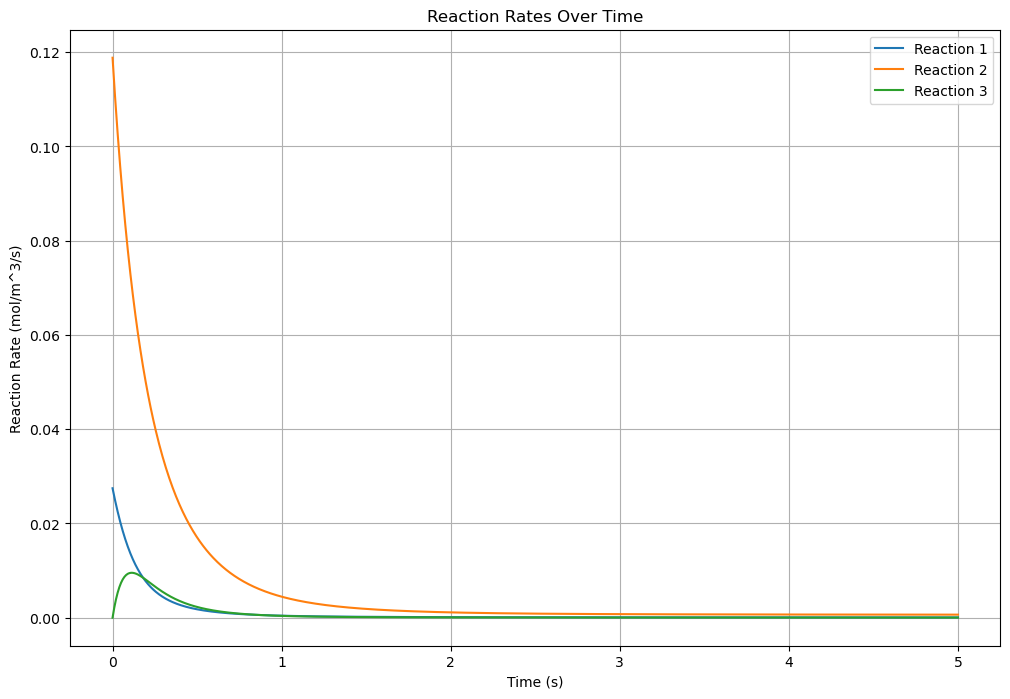

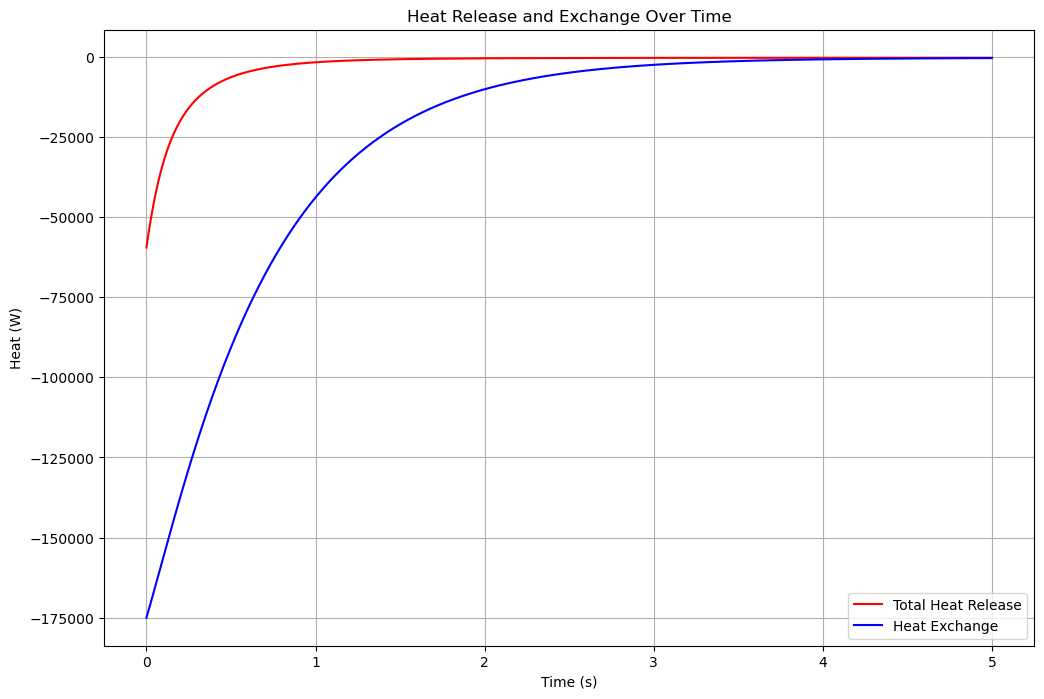

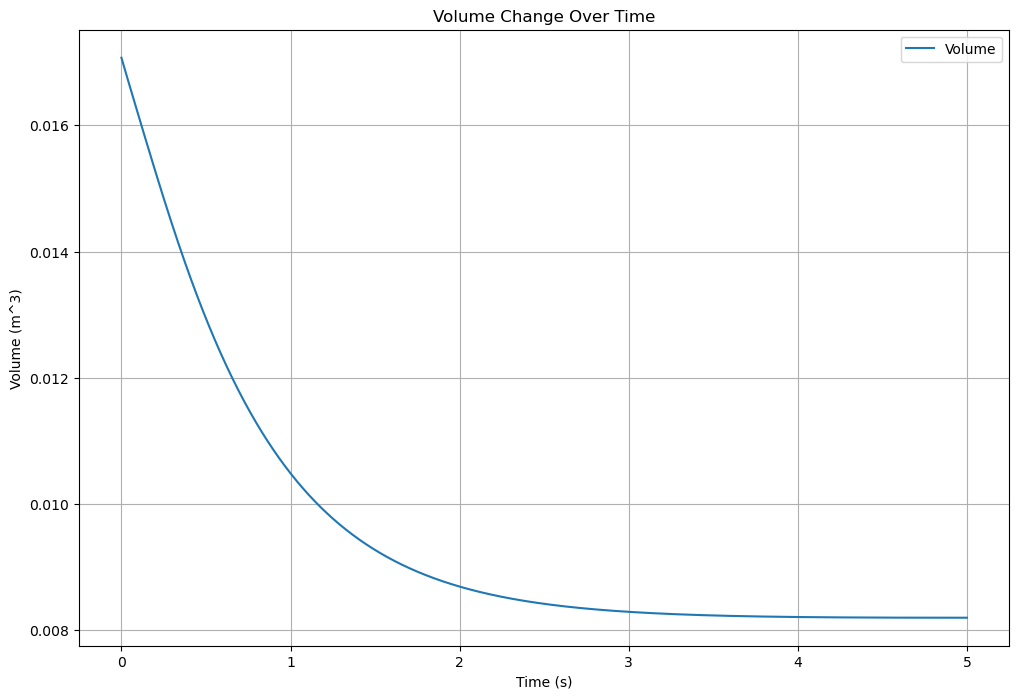

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


class Reaction:
    def __init__(self, reactants, products, k, Ea, deltaH, adsorption_coeffs=None):
      
        self.reactants = reactants
        self.products = products
        self.k = k  # Pre-exponential factor
        self.Ea = Ea  # Activation energy in J/mol
        self.deltaH = deltaH  # Enthalpy change (J/mol)
        self.adsorption_coeffs = adsorption_coeffs or {}  # Adsorption coefficients

def arrhenius_rate_constant(k, Ea, T, R=8.314):
    # Basic Arrhenius equation
    return k * np.exp(-Ea / (R * T))

def lhhw_rate(reaction, state, T, R=8.314, activity_coeffs=None):
    k = arrhenius_rate_constant(reaction.k, reaction.Ea, T)
    num = k
    denom = 1

    for reactant, stoichiometry in reaction.reactants.items():
        concentration = state[reactant]
        activity = concentration * activity_coeffs[reactant](T, state) if activity_coeffs and reactant in activity_coeffs else concentration
        num *= activity ** stoichiometry  

    for species, K in reaction.adsorption_coeffs.items():
        concentration = state[species]
        activity = concentration * activity_coeffs[species](T, state) if activity_coeffs and species in activity_coeffs else concentration
        denom += K * activity

    return num / denom

def peng_robinson_pressure(T, V, a, b, n_total, R=8.314):
    return (n_total * R * T) / (V - n_total * b) - (n_total**2 * a) / (V * (V + n_total * b) + n_total * b * (V - n_total * b))


def peng_robinson_volume(T, P, a, b, n_total, R=8.314):
    """Calculates the volume using the Peng-Robinson equation of state."""
    # Cubic equation coefficients
    A = P * a * n_total**2 / R**2 / T**2
    B = P * b * n_total / R / T
    
    # Solve the cubic equation for the compressibility factor (Z)
    coeffs = [1, -1 + B, A - 3*B**2 - 2*B, -A*B + B**2 + B**3]
    roots = np.roots(coeffs)
    real_roots = roots[np.isreal(roots)]
    Z = max(real_roots) # Choose the largest real root as the compressibility factor
    
    # Calculate the volume
    V = Z * n_total * R * T / P
    return V

def calculate_heat_exchange(U, A, T, T_ext):
    return U * A * (T_ext - T)

# Define the NRTL model parameters for all components
nrtl_params = {
    'NH3': {
        'H2O': {'tau': 1.2, 'alpha': 0.3},
        'CH4': {'tau': 0.8, 'alpha': 0.2},
        'CO2': {'tau': 1.5, 'alpha': 0.25},
        'NO': {'tau': 1.0, 'alpha': 0.35},
        'O2': {'tau': 0.7, 'alpha': 0.3},
        'H2': {'tau': 1.3, 'alpha': 0.2},
        'CO': {'tau': 1.1, 'alpha': 0.3},
    },
    'H2O': {
        'NH3': {'tau': 0.5, 'alpha': 0.3},
        'CH4': {'tau': 0.9, 'alpha': 0.2},
        'CO2': {'tau': 0.6, 'alpha': 0.25},
        'NO': {'tau': 0.8, 'alpha': 0.35},
        'O2': {'tau': 1.0, 'alpha': 0.3},
        'H2': {'tau': 0.7, 'alpha': 0.2},
        'CO': {'tau': 1.2, 'alpha': 0.3},
    },
    'CH4': {
        'NH3': {'tau': 1.1, 'alpha': 0.2},
        'H2O': {'tau': 1.3, 'alpha': 0.2},
        'CO2': {'tau': 1.0, 'alpha': 0.25},
        'NO': {'tau': 0.7, 'alpha': 0.35},
        'O2': {'tau': 0.9, 'alpha': 0.3},
        'H2': {'tau': 1.2, 'alpha': 0.2},
        'CO': {'tau': 0.8, 'alpha': 0.3},
    },
    'CO2': {
        'NH3': {'tau': 1.4, 'alpha': 0.25},
        'H2O': {'tau': 1.2, 'alpha': 0.25},
        'CH4': {'tau': 1.3, 'alpha': 0.25},
        'NO': {'tau': 1.1, 'alpha': 0.35},
        'O2': {'tau': 0.8, 'alpha': 0.3},
        'H2': {'tau': 1.5, 'alpha': 0.2},
        'CO': {'tau': 0.9, 'alpha': 0.3},
    },
    'NO': {
        'NH3': {'tau': 1.2, 'alpha': 0.35},
        'H2O': {'tau': 1.1, 'alpha': 0.35},
        'CH4': {'tau': 1.0, 'alpha': 0.35},
        'CO2': {'tau': 1.4, 'alpha': 0.35},
        'O2': {'tau': 1.3, 'alpha': 0.3},
        'H2': {'tau': 0.9, 'alpha': 0.2},
        'CO': {'tau': 0.7, 'alpha': 0.3},
    },
    'O2': {
        'NH3': {'tau': 0.7, 'alpha': 0.3},
        'H2O': {'tau': 1.0, 'alpha': 0.3},
        'CH4': {'tau': 0.9, 'alpha': 0.3},
        'CO2': {'tau': 1.2, 'alpha': 0.3},
        'NO': {'tau': 1.3, 'alpha': 0.3},
        'H2': {'tau': 1.1, 'alpha': 0.2},
        'CO': {'tau': 1.5, 'alpha': 0.3},
    },
    'H2': {
        'NH3': {'tau': 1.1, 'alpha': 0.2},
        'H2O': {'tau': 0.7, 'alpha': 0.2},
        'CH4': {'tau': 1.3, 'alpha': 0.2},
        'CO2': {'tau': 1.5, 'alpha': 0.2},
        'NO': {'tau': 0.9, 'alpha': 0.2},
        'O2': {'tau': 1.1, 'alpha': 0.2},
        'CO': {'tau': 1.2, 'alpha': 0.3},
    },
    'CO': {
        'NH3': {'tau': 1.1, 'alpha': 0.3},
        'H2O': {'tau': 1.2, 'alpha': 0.3},
        'CH4': {'tau': 0.8, 'alpha': 0.3},
        'CO2': {'tau': 0.9, 'alpha': 0.3},
        'NO': {'tau': 0.7, 'alpha': 0.3},
        'O2': {'tau': 1.5, 'alpha': 0.3},
        'H2': {'tau': 1.2, 'alpha': 0.3},
    }
}

def nrtl_activity_coefficient(component, T, state, params):
    x = np.array([state[comp] for comp in state.keys()])
    components = list(state.keys())
    i = components.index(component)
    gamma_i = 0

    for j, comp_j in enumerate(components):
        if comp_j == component:
            continue
        
        tau_ji = params[comp_j][component]['tau']
        alpha_ji = params[comp_j][component]['alpha']
        G_ji = np.exp(-alpha_ji * tau_ji)
        
        tau_ij = params[component][comp_j]['tau']
        alpha_ij = params[component][comp_j]['alpha']
        G_ij = np.exp(-alpha_ij * tau_ij)
        
        sum_G_jk_x_k = sum(G_ij * state[comp_k] for comp_k in components)
        sum_G_ik_x_k = sum(G_ji * state[comp_k] for comp_k in components)
        
        term1 = (tau_ji * G_ji * state[comp_j]) / sum_G_jk_x_k
        term2 = (state[comp_j] * G_ij * tau_ij) / sum_G_ik_x_k
        term3 = 1 - sum_G_jk_x_k / sum_G_ik_x_k
        
        gamma_i += term1 + term2 * term3
    
    return np.exp(gamma_i)

# Define activity coefficient functions using the NRTL model
def activity_coeff_NH3(T, state):
    return nrtl_activity_coefficient('NH3', T, state, nrtl_params)

def activity_coeff_H2O(T, state):
    return nrtl_activity_coefficient('H2O', T, state, nrtl_params)

def activity_coeff_CH4(T, state):
    return nrtl_activity_coefficient('CH4', T, state, nrtl_params)

def activity_coeff_CO2(T, state):
    return nrtl_activity_coefficient('CO2', T, state, nrtl_params)

def activity_coeff_NO(T, state):
    return nrtl_activity_coefficient('NO', T, state, nrtl_params)

def activity_coeff_O2(T, state):
    return nrtl_activity_coefficient('O2', T, state, nrtl_params)

def activity_coeff_H2(T, state):
    return nrtl_activity_coefficient('H2', T, state, nrtl_params)

def activity_coeff_CO(T, state):
    return nrtl_activity_coefficient('CO', T, state, nrtl_params)

activity_coeffs = {
    'NH3': activity_coeff_NH3,
    'H2O': activity_coeff_H2O,
    'CH4': activity_coeff_CH4,
    'CO2': activity_coeff_CO2,
    'NO': activity_coeff_NO,
    'O2': activity_coeff_O2,
    'H2': activity_coeff_H2,
    'CO': activity_coeff_CO,
}

# Example state for testing
state = {'NH3': 0.1, 'H2O': 0.3, 'CH4': 0.1, 'CO2': 0.1, 'NO': 0.1, 'O2': 0.1, 'H2': 0.1, 'CO': 0.1}

# Test the activity coefficient functions
T = 298.15  # Temperature in Kelvin
for component in state.keys():
    print(f"Activity coefficient of {component}: {activity_coeffs[component](T, state)}")
    
    
# Mass transfer function
def calculate_mass_transfer_rate(k, A, C_bulk, C_interface):
    """Calculates the mass transfer rate based on the film theory model."""
    return k * A * (C_bulk - C_interface)

# Main ODE function
def odes(t, y, species, reactions, V, Cp, U, A, T_ext, component_params, mass_transfer_coeffs, interfacial_area, activity_coeffs=None):
    state = dict(zip(species, y[:-2]))
    T = y[-2]
    P = y[-1]
    dydt = np.zeros(len(species) + 2)  # dydt will include dP/dt
    R = 8.314  # Universal gas constant

    # Peng-Robinson Parameter Update
    y_current = y[:-2] / np.sum(y[:-2])  # Mole fractions
    a_matrix = np.array([[component_params[i]['a'] for i in species] for _ in species])
    a_terms = np.sqrt(a_matrix * a_matrix.T) * y_current[:, np.newaxis] * y_current[np.newaxis, :]
    a = np.sum(a_terms)
    b = np.sum(y_current * np.array([component_params[i]['b'] for i in species]))

    # Calculate derivatives of a and b (dadt, dbdt)
    dadt = 2 * np.sum(
        (a_matrix * a_matrix.T)**0.5 * (dydt[:-2, np.newaxis] * y_current[np.newaxis, :] + y_current[:, np.newaxis] * dydt[:-2, np.newaxis].T)
    )
    dbdt = np.sum(dydt[:-2] * np.array([component_params[i]['b'] for i in species]))

    for reaction in reactions:
        rate = lhhw_rate(reaction, state, T, R, activity_coeffs)
        for reactant, stoichiometry in reaction.reactants.items():
            dydt[species.index(reactant)] -= rate * stoichiometry
        for product, stoichiometry in reaction.products.items():
            dydt[species.index(product)] += rate * stoichiometry

    # Heat exchange
    Q = calculate_heat_exchange(U, A, T, T_ext)
    total_heat_release = np.sum([reaction.deltaH * lhhw_rate(reaction, state, T, R, activity_coeffs) for reaction in reactions])
    n_total = np.sum(y[:-2])

    dydt[-2] = (Q - total_heat_release) / (n_total * Cp)  # dT/dt

    # Mass Transfer
    dVdt = 0.0  # Initialize volume change rate
    for i, sp in enumerate(species):
        k_mt = mass_transfer_coeffs[sp]
        C_bulk = y[i] / V
        C_interface = 0.8 * C_bulk
        mass_transfer_rate = calculate_mass_transfer_rate(k_mt, interfacial_area, C_bulk, C_interface)
        dydt[i] += mass_transfer_rate / V
        # Update dVdt based on mass transfer rate and molar volume (assuming ideal gas for simplicity)
        dVdt += mass_transfer_rate * R * T / P  

    # Pressure Change using Peng-Robinson with updated a, b, and V
    dTdt = dydt[-2]
    dndt = np.sum(dydt[:-2])
    dPdt = (R / V) * (n_total * dTdt + T * dndt) - (P / (V - n_total * b)) * (
        n_total * dbdt - (a / (2 * np.sqrt(a * b))) * dadt
    ) + (P / V) * dVdt  # Include the calculated dVdt

    dydt[-1] = dPdt
    return dydt


class Simulator:
    def __init__(self, species, initial_state, T0, P0, reactions, V, Cp, U, A, T_ext, component_params, mass_transfer_coeffs, interfacial_area):

        self.species = species
        self.initial_concentrations = np.array([initial_state[sp] for sp in species] + [T0, P0])
        self.reactions = reactions
        self.V = V
        self.Cp = Cp
        self.U = U
        self.A = A
        self.T_ext = T_ext
        self.mass_transfer_coeffs = mass_transfer_coeffs
        self.interfacial_area = interfacial_area
        
        # Peng-Robinson parameters for individual components
        self.component_params = {
            'CH4': {'a': 0.22862, 'b': 4.2782e-5},
            'O2': {'a': 0.13780, 'b': 3.1830e-5},
            'CO2': {'a': 0.39164, 'b': 4.2670e-5},
            'H2O': {'a': 0.55364, 'b': 3.0490e-5},
            'NH3': {'a': 0.42245, 'b': 3.7070e-5},
            'NO': {'a': 0.14276, 'b': 2.7890e-5},
            'H2': {'a': 0.02476, 'b': 2.6610e-5},
            'CO': {'a': 0.15052, 'b': 3.9850e-5}
        }

        # Calculate Peng-Robinson parameters for the initial mixture
        y_initial = [initial_state[sp] / sum(initial_state.values()) for sp in species]
        self.a = sum(
            sum(
                y_initial[i] * y_initial[j] * (self.component_params[species[i]]['a'] * self.component_params[species[j]]['a'])**0.5 
                for j in range(len(species))
            ) for i in range(len(species))
        )
        self.b = sum(y_initial[i] * self.component_params[species[i]]['b'] for i in range(len(species)))

    def run_simulation(self, total_time, method='BDF', t_eval=None, atol=1e-10, rtol=1e-8, activity_coeffs=None):
      
        if t_eval is None:
            t_eval = np.linspace(0, total_time, 1000)

        solution = solve_ivp(
            odes, [0, total_time], self.initial_concentrations,
            args=(self.species, self.reactions, self.V, self.Cp, self.U, self.A, self.T_ext, 
                  self.component_params, self.mass_transfer_coeffs, self.interfacial_area, activity_coeffs),  # Removed 8.314 from args
            method=method, t_eval=t_eval, atol=atol, rtol=rtol
        )
        self.times = solution.t
        self.concentrations = solution.y[:-2]
        self.temperature = solution.y[-2]
        self.pressure = solution.y[-1]

    def calculate_conversion(self, species_name):
        if self.concentrations is None:
            raise ValueError("Simulation must be run before calculating conversion.")
        
        initial_conc = self.initial_concentrations[self.species.index(species_name)]
        final_conc = self.concentrations[self.species.index(species_name), -1]
        if initial_conc == 0:
            raise ValueError("Initial concentration of the species cannot be zero.")
        return (initial_conc - final_conc) / initial_conc

    def calculate_extent_of_reaction(self, reaction_index):
        if self.concentrations is None:
            raise ValueError("Simulation must be run before calculating extent of reaction.")

        reaction = self.reactions[reaction_index]
        reactant_name = list(reaction.reactants.keys())[0]
        reactant_idx = self.species.index(reactant_name)
        stoichiometry_reactant = reaction.reactants[reactant_name]

        initial_conc = self.initial_concentrations[reactant_idx]
        final_conc = self.concentrations[reactant_idx, -1]
        return (initial_conc - final_conc) / stoichiometry_reactant

    def calculate_selectivity(self, product_name, reactant_name):
        if self.concentrations is None:
            raise ValueError("Simulation must be run before calculating selectivity.")
        extent_reactant = self.calculate_extent_of_reaction(next(
            i for i, r in enumerate(self.reactions) if reactant_name in r.reactants
        ))
        product_idx = self.species.index(product_name)
        stoichiometry_product = next(
            r.products[product_name] for r in self.reactions if product_name in r.products
        )
        return (self.concentrations[product_idx, -1] / extent_reactant / stoichiometry_product)

    def calculate_yield(self, product_name, reactant_name):
        if self.concentrations is None:
            raise ValueError("Simulation must be run before calculating yield.")
        return self.calculate_conversion(reactant_name) * self.calculate_selectivity(product_name, reactant_name)

class Plotter:
    def __init__(self, simulator):
        self.simulator = simulator

    def plot_concentrations(self, species_to_plot=None, log_scale=False):
        if species_to_plot is None:
            species_to_plot = self.simulator.species

        plt.figure(figsize=(12, 8))
        for sp in species_to_plot:
            idx = self.simulator.species.index(sp)
            plt.plot(self.simulator.times, self.simulator.concentrations[idx], label=sp)

        plt.xlabel('Time (s)')
        plt.ylabel('Concentration (mol/m^3)' if not log_scale else 'log(Concentration) (mol/m^3)')
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.title('Concentration of Species Over Time')
        plt.grid(True)
        plt.show()

    def plot_temperature_pressure(self, log_scale=False):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(self.simulator.times, self.simulator.temperature, label='Temperature', color='red')
        plt.xlabel('Time (s)')
        plt.ylabel('Temperature (K)')
        plt.legend()
        plt.title('Temperature Over Time')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.plot(self.simulator.times, self.simulator.pressure, label='Pressure', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Pressure (Pa)')
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.title('Pressure Over Time')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    def plot_reaction_rates(self):
        """Plots reaction rates over time for all reactions."""
        plt.figure(figsize=(12, 8))
        for i, reaction in enumerate(self.simulator.reactions):
            rates = [lhhw_rate(reaction, dict(zip(self.simulator.species, conc)), temp) 
                     for conc, temp in zip(self.simulator.concentrations.T, self.simulator.temperature)]  # Calculate rates at each time point
            plt.plot(self.simulator.times, rates, label=f'Reaction {i+1}')

        plt.xlabel('Time (s)')
        plt.ylabel('Reaction Rate (mol/m^3/s)')
        plt.legend()
        plt.title('Reaction Rates Over Time')
        plt.grid(True)
        plt.show()

    def plot_extent_of_reactions(self):
        """Plots the extent of reactions over time for all reactions."""
        plt.figure(figsize=(12, 8))
        for i in range(len(self.simulator.reactions)):
            extent = [self.simulator.calculate_extent_of_reaction(i) for _ in self.simulator.times]
            plt.plot(self.simulator.times, extent, label=f'Reaction {i+1}')

        plt.xlabel('Time (s)')
        plt.ylabel('Extent of Reaction')
        plt.legend()
        plt.title('Extent of Reactions Over Time')
        plt.grid(True)
        plt.show()

    def plot_heat_release_and_exchange(self):
        """Plots total heat release from reactions and heat exchanged with surroundings."""
        total_heat_release = [
            np.sum([r.deltaH * lhhw_rate(r, dict(zip(self.simulator.species, conc)), temp) for r in self.simulator.reactions])
            for conc, temp in zip(self.simulator.concentrations.T, self.simulator.temperature)
        ]
        heat_exchange = [calculate_heat_exchange(self.simulator.U, self.simulator.A, temp, self.simulator.T_ext)
                         for temp in self.simulator.temperature]

        plt.figure(figsize=(12, 8))
        plt.plot(self.simulator.times, total_heat_release, label='Total Heat Release', color='red')
        plt.plot(self.simulator.times, heat_exchange, label='Heat Exchange', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('Heat (W)')
        plt.legend()
        plt.title('Heat Release and Exchange Over Time')
        plt.grid(True)
        plt.show()
        
    def plot_volume_change(self):
        """Plots the volume change over time due to reactions."""
        volumes = [peng_robinson_volume(temp, pres, self.simulator.a, self.simulator.b, np.sum(conc)) 
                   for conc, temp, pres in zip(self.simulator.concentrations.T, self.simulator.temperature, self.simulator.pressure)]

        plt.figure(figsize=(12, 8))
        plt.plot(self.simulator.times, volumes, label='Volume')
        plt.xlabel('Time (s)')
        plt.ylabel('Volume (m^3)')
        plt.legend()
        plt.title('Volume Change Over Time')
        plt.grid(True)
        plt.show()

# Define activity coefficient functions (replace with actual models)
def activity_coeff_NH3(T, state):
    # Example: Simplified NRTL model
    return 1.0 + 0.2 * state['H2O']  # Adjust based on your system

def activity_coeff_H2O(T, state):
    # Example: Simplified NRTL model
    return 1.0 + 0.3 * state['NH3']  # Adjust based on your system

activity_coeffs = {
    'NH3': activity_coeff_NH3,
    'H2O': activity_coeff_H2O,
    # Add more activity coefficient functions as needed
}

# Define Peng-Robinson parameters for individual components
component_params = {
    'CH4': {'a': 0.22862, 'b': 4.2782e-5},
    'O2': {'a': 0.13780, 'b': 3.1830e-5},
    'CO2': {'a': 0.39164, 'b': 4.2670e-5},
    'H2O': {'a': 0.55364, 'b': 3.0490e-5},
    'NH3': {'a': 0.42245, 'b': 3.7070e-5},
    'NO': {'a': 0.14276, 'b': 2.7890e-5},
    'H2': {'a': 0.02476, 'b': 2.6610e-5},
    'CO': {'a': 0.15052, 'b': 3.9850e-5}
}
# Define initial conditions and parameters
initial_state = {'NH3': 0.1, 'CH4': 0.01, 'CO2': 0.0, 'NO': 0.0, 'O2': 0.21, 'H2O': 0.0, 'H2': 0.0, 'CO': 0.0}
T0 = 650  # Initial temperature (K)
P0 = 101325  # Initial pressure (Pa)
total_time = 5  # Total simulation time
species = list(initial_state.keys())
initial_concentrations = [initial_state[sp] for sp in species] + [T0, P0]

# Heat capacity, volume, heat transfer coefficient, external temperature, surface area
Cp = 1000  # J/mol/K
V = 1  # m^3
U = 500  # W/m^2/K
A = 1  # m^2
T_ext = 300  # K


# Define reactions with LHHW kinetics and adjusted parameters
reactions = [
    Reaction(reactants={'CH4': 1, 'O2': 2}, products={'CO2': 1, 'H2O': 2}, k=1e3, Ea=15000, deltaH=-802e3,
             adsorption_coeffs={'CH4': 1e-3, 'O2': 1e-3, 'CO2': 1e-4, 'H2O': 1e-4}),
    Reaction(reactants={'NH3': 1, 'O2': 1.5}, products={'NO': 1, 'H2O': 1.5}, k=5e2, Ea=20000, deltaH=-315e3,
             adsorption_coeffs={'NH3': 1e-3, 'O2': 1e-3, 'NO': 1e-4, 'H2O': 1e-4}),
    Reaction(reactants={'CH4': 1, 'H2O': 1}, products={'CO': 1, 'H2': 3}, k=1e4, Ea=25000, deltaH=206e3,
             adsorption_coeffs={'CH4': 1e-3, 'H2O': 1e-3, 'CO': 1e-4, 'H2': 1e-4})
]

# Instantiate Simulator and Plotter with component_params passed to the Simulator constructor
mass_transfer_coeffs = {'NH3': 0.01, 'CH4': 0.005, 'CO2': 0.008, 'NO': 0.006, 'O2': 0.012, 'H2O': 0.009, 'H2': 0.015, 'CO': 0.007}  
interfacial_area = 0.5 
simulator = Simulator(species, initial_state, T0, P0, reactions, V, Cp, U, A, T_ext, component_params, mass_transfer_coeffs, interfacial_area)
plotter = Plotter(simulator)



# Run the simulation with activity coefficients
simulator.run_simulation(total_time, activity_coeffs=activity_coeffs)

# Plotting
plotter.plot_concentrations()
plotter.plot_temperature_pressure()


# Example calculations
ch4_conversion = simulator.calculate_conversion('CH4')
co2_selectivity = simulator.calculate_selectivity('CO2', 'CH4')
co2_yield = simulator.calculate_yield('CO2', 'CH4')

print(f"CH4 conversion: {ch4_conversion:.2f}")
print(f"CO2 selectivity from CH4: {co2_selectivity:.2f}")
print(f"CO2 yield from CH4: {co2_yield:.2f}")

# Additional plots for individual species and total concentrations
plotter.plot_reaction_rates()
plotter.plot_heat_release_and_exchange()
plotter.plot_volume_change()
